# Study Clean Catalan Elections Dataset

Load libraries:

In [1]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import textdistance
from tqdm import tqdm
from unidecode import unidecode
import logging

pp = pprint.PrettyPrinter(indent=2)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

Load the clean dataset:

In [2]:
df = pd.read_pickle('../../data/processed/catalan-elections-clean-data.pkl')
df_original = df.copy()

## Dataset Structure 

Visualize the structure of the dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12339340 entries, 0 to 12339339
Data columns (total 23 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   index_autonumeric       int64         
 1   nom_eleccio             object        
 2   id_nivell_territorial   object        
 3   nom_nivell_territorial  object        
 4   territori_codi          object        
 5   territori_nom           object        
 6   seccio                  Int64         
 7   vots                    int32         
 8   escons                  float64       
 9   districte               Int64         
 10  mesa                    object        
 11  party_code              int32         
 12  party_name              object        
 13  party_abbr              object        
 14  party_color             object        
 15  clean_party_name        object        
 16  clean_party_abbr        object        
 17  type                    object        
 18  

| Column name               | Description                                            | Type      |
|---------------------------|--------------------------------------------------------|-----------|
| INDEX_AUTONUMERIC         | Autonumeric index identifier for the row               | Number    |
| NOM_ELECCIO               | Name of the electoral process                          | Plain Text|
| ID_NIVELL_TERRITORIAL     | Identifier of the territorial level (Municipality, Vegueria, County...) | Plain Text|
| NOM_NIVELL_TERRITORIAL    | Name of the territorial level of the record (Municipality, County...) | Plain Text|
| TERRITORI_CODI            | Territory code                                         | Plain Text|
| TERRITORI_NOM             | Name of the territory                                  | Plain Text|
| DISTRICTE                 | Electoral district                                     | Plain Text|
| SECCIO                    | Electoral section                                      | Plain Text|
| MESA                      | Electoral table                                        | Plain Text|
| PARTY_CODE                | Code of the party                                      | Number    |
| PARTY_NAME                | Name of the party                                      | Plain Text|
| PARTY_ABBR                | Acronym of the party                                   | Plain Text|
| PARTY_COLOR               | Color of the party                                     | Plain Text|
| VOTS                      | Votes of the party                                     | Number    |
| ESCONS                    | Seats of the party                                     | Number    |
| TYPE                      | Type of election                                       | Plain Text|
| YEAR                      | Year when the election took place                      | Number    |
| MONTH                     | Month when the election took place                     | Number    |
| DAY                       | Day when the election took place                       | Number    |
| DATE                      | Date when the election took place                      | Datetime  |

## Group candidatures

One of the challenges of forecasting elections is the large number of candidatures. Most of the candidatures belong to a big party, but there are also many small parties and independent candidatures. We need to group the candidatures that belong to the same party in order to get the historical data of the biggest parties.

We will try to group the candidatures automatically, but this will only be useful when the candidatures have a similar name. When the candidatures have a different name (for example parties that have merged, or parties that have changed their name), we will need to group them manually.

There are many ways to group the candidatures. We could use the code, the acronym, the name or the columns ``AGRUPACIO_*``, but we need to keep in mind that these columns have 77% of empty values. We will start by grouping the candidatures by the code.

The small parties or independent candidatures could be grouped in a single category called "Others".

### Group party by code

The first step is to analyze the number of individual candidatures. This will help us to know whether the groping is useful or not.

In [4]:
# Show the number of unique parties by code
candidatures = len(df['party_code'].unique())
candidatures

920

In [5]:
unique_df = df[['party_code', 'party_name', 'party_abbr']].drop_duplicates()
sorted_unique_df = unique_df.sort_values(by='party_code')
sorted_unique_df

,party_code,party_name,party_abbr
12174323,-2147483648,BARCELONA ETS TÚ,BCN ETS TÚ
0,1,Conservadors de Catalunya,C.i.C.
171727,2,Partit dels Comunistes de Catalunya,PCC
226225,3,Unificació Comunista d'Espanya,U.C.E.
1,4,Partit Socialista Unificat de Catalunya,PSUC
...,...,...,...
12174318,431664190,TOT(S) VILALLONGA DEL CAMP,TOT(S)
12174319,431704190,SOM-HI VILA-RODONA,SV
12174320,439054190,FEM SALOU FEM REPÚBLICA,SR
12174321,439054192,UNIDOS SALOU COSTA DORADA,UNIDOS SALOU


In [6]:
# Group by 'party_code', then aggregate to get the count and the first 'party_name'
count_df = (
    unique_df.groupby("party_code")
    .agg(
        count=("party_code", "size"),  # Count the number of occurrences
        first_party_name=(
            "party_name",
            "first",
        ),  # Get the first 'party_name'
    )
    .reset_index()
)
sorted_count_df = count_df.sort_values(by="count", ascending=False).reset_index(
    drop=True
)
sorted_count_df

,party_code,count,first_party_name
0,301,5,Ciutadans-Partido de la Ciudadanía
1,86,4,Partit Popular
2,1083,3,Junts per Catalunya
3,662,3,Partit Animalista Contra el Maltractament Animal
4,643,2,Escons en Blanc
...,...,...,...
915,614,1,Iniciativa per Catalunya Verds-EUiA: L'Esquerra
916,615,1,Salamanca-Zamora-León
917,616,1,Libertas-Ciudadanos de España
918,617,1,Los Verdes-Grupo Verde Europeo


In [7]:
# Merge count_df and unique_df by 'party_code'
merged_df = pd.merge(
    count_df, unique_df, on="party_code", how="inner"
)

# Sort merged_df by 'count' and 'party_code'
sorted_merged_df = merged_df.sort_values(
    by=["count", "party_code"], ascending=[False, True]
).reset_index(drop=True)

sorted_merged_df

,party_code,count,first_party_name,party_name,party_abbr
0,301,5,Ciutadans-Partido de la Ciudadanía,Ciutadans-Partido de la Ciudadanía,C's
1,301,5,Ciutadans-Partido de la Ciudadanía,Ciutadans-Partido de la Ciudadanía,Cs
2,301,5,Ciutadans-Partido de la Ciudadanía,CIUTADANS-PARTIDO DE LA CIUDADANIA,CS
3,301,5,Ciutadans-Partido de la Ciudadanía,CIUTADANS-PARTIDO DE LA CIUDADANÍA,Cs
4,301,5,Ciutadans-Partido de la Ciudadanía,CIUTADANS-PARTIDO DE LA CIUDADANIA,Cs
...,...,...,...,...,...
952,431664190,1,TOT(S) VILALLONGA DEL CAMP,TOT(S) VILALLONGA DEL CAMP,TOT(S)
953,431704190,1,SOM-HI VILA-RODONA,SOM-HI VILA-RODONA,SV
954,439054190,1,FEM SALOU FEM REPÚBLICA,FEM SALOU FEM REPÚBLICA,SR
955,439054192,1,UNIDOS SALOU COSTA DORADA,UNIDOS SALOU COSTA DORADA,UNIDOS SALOU


After the cleaning we have **920 candidatures**, that is a huge reduction compared to the original dataset, which had **7351 candidatures**.

But there are still many candidatures that could be grouped into the same party. To do this, we need to perform language processing to group the candidatures that have a similar name.

### Group party by name similarity

Grouping the candidatures by name similarity is a complex task. We will use the Levenshtein distance to measure the similarity between the names of the candidatures. The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

Joining similar parties (or candidatures) into the same party code is not a trivial task. We must be careful when joining the parties, because some similar candidatures could belong to different parties. We will ensure that grouped candidatures hasn't competed in the same election.

This function will help us to discard those candidatures with similar name that have competed in the same election, and therefore, they are different parties.

Also, we need to take into account that the candidatures with similar name could belong to the same `party_code`. We only need to group the candidatures that have different `party_code`.

In [8]:
def parties_competed_together_matrix(df, column="clean_party_name"):
    # Filter DataFrame for territorial level "MU"
    df_filtered = df[df["id_nivell_territorial"] == "MU"]

    # Group by party name and aggregate unique election identifiers into sets
    party_elections = df_filtered.groupby(column)["nom_eleccio"].apply(set)

    # Get a sorted list of unique party names for consistent ordering
    party_names = sorted(party_elections.index)

    # Create an empty boolean matrix
    matrix_size = len(party_names)
    bool_matrix = pd.DataFrame(False, index=party_names, columns=party_names)

    # Iterate through each party name once, showing progress with tqdm
    for i in tqdm(range(matrix_size), desc="Calculate parties that competed together"):
        party_name_i = party_names[i]
        elections_i = party_elections[party_name_i]
        for j in range(i + 1, matrix_size):
            party_name_j = party_names[j]
            # Compare sets of election IDs for common elements
            # Set the cell to True if there's an intersection
            bool_matrix.at[party_name_i, party_name_j] = bool_matrix.at[
                party_name_j, party_name_i
            ] = not elections_i.isdisjoint(party_elections[party_name_j])

    return bool_matrix

A party code can have different names, that means the similar names could belong to the same party code. We will create a function to check if the similar names belong to the same party code. If they belong to the same party code, we won't take them into account as they are already grouped.

We will create a function that checks whether the similar names belong to the same party code. If they belong to the same party code, it will return True, otherwise it will return False.

In [9]:
def same_party_code_matrix(df, column="party_name"):
    # Group by party name and aggregate party codes into sets
    party_codes = df.groupby(column)["party_code"].apply(set)

    # Get a sorted list of unique party names for consistent ordering
    party_names = sorted(party_codes.index)

    # Create an empty boolean matrix
    matrix_size = len(party_names)
    bool_matrix = pd.DataFrame(False, index=party_names, columns=party_names)

    # Iterate through each party name once
    for i in tqdm(range(matrix_size), desc="Calculating same party codes matrix"):
        party_name_i = party_names[i]
        codes_i = party_codes[party_name_i]
        for j in range(i + 1, matrix_size):
            party_name_j = party_names[j]
            # Compare sets of party codes for common elements
            # Set the cell to True if there's an intersection
            bool_matrix.at[party_name_i, party_name_j] = bool_matrix.at[
                party_name_j, party_name_i
            ] = not codes_i.isdisjoint(party_codes[party_name_j])

    return bool_matrix

In [10]:
df[df["party_code"] == 86][["party_code", "clean_party_name"]].drop_duplicates()

,party_code,clean_party_name
698481,86,partit popular
6720119,86,partit popular /partido popular
10044037,86,partido popular/partit popular
12174026,86,partit popular / partido popular


In [11]:
def calculate_distance_matrix(
    party_names, distance_algorithm=textdistance.levenshtein.distance
):
    """Calculate a distance matrix for a list of strings using a distance algorithm

    Set to max_distance for the diagonal and below the diagonal to avoid taking into account a value 2 times

    Args:
    party_names: A list with the party names (or abreviations) to calculate the distance matrix for
    distance_algorithm: A distance algorithm from the textdistance library
    column_name: The name of the column in the DataFrame containing the party strings
    """
    n = len(party_names)

    distance_matrix = np.zeros((n, n), dtype=float)  # Initialize a matrix with zeros
    max_distance = 100.0

    # Only calculate for the upper half of the matrix
    for i in tqdm(range(n), desc="Calculating distances"):
        for j in range(i + 1, n):
            distance_matrix[i, j] = distance_algorithm(party_names[i], party_names[j])
            distance_matrix[j, i] = max_distance

    # Making sure the diagonal is high to simulate distance to itself (will be filtered out)
    np.fill_diagonal(distance_matrix, 100.0)

    # Convert the NumPy array to a pandas DataFrame
    return pd.DataFrame(distance_matrix, index=party_names, columns=party_names)

Now we have a list of similar names that belong to the same party code. We will group the candidatures that have different party codes. To do this, we will create a new column called ``party_group``. This column will store the party code of the grouped candidatures.

Each similar name has its own party code, so we must choose which code to keep. We will choose the code with the most votes.

In [12]:
def extract_true_pairs(similar_parties_matrix):
    """
    Extract pairs of parties with True values from a similarity matrix.

    Parameters:
    - similar_parties_matrix: DataFrame, a matrix indicating similarity (True) between pairs of parties.

    Returns:
    - DataFrame with two columns (party_1, party_2) listing all pairs of parties with True values.
    """
    party_pairs = []

    for row in tqdm(similar_parties_matrix.index, desc="Extracting true pairs"):
        for col in similar_parties_matrix.columns:
            if row != col and similar_parties_matrix.at[row, col]:
                # Append the pair to the list if the parties are different
                party_pairs.append({"party_1": row, "party_2": col})

    # Convert the list of dictionaries to a DataFrame
    parties_table = pd.DataFrame(party_pairs, columns=["party_1", "party_2"])

    return parties_table

In [13]:
def add_most_voted_party_code_column(most_voted_matrix, similar_parties):
    """
    Adds a 'most_voted_party_code' column to the similar_parties dataframe.

    Parameters:
    - most_voted_matrix: DataFrame, dataframe matrix party columns.
    - similar_parties: DataFrame, DataFrame with two columns (party_1, party_2).

    Returns:
    - DataFrame, the original dataframe with an added 'most_voted_party_code' column.
    """
    similar_parties["most_voted_party_code"] = similar_parties.apply(
        lambda row: most_voted_matrix.at[row["party_1"], row["party_2"]], axis=1
    )
    return similar_parties


In [14]:
def get_party_codes_votes(df, territory="CA"):
    """
    Get the party codes and their sum of votes for a list of party names.

    Parameters:
    - df: DataFrame, the original dataframe with party information.
    - territory: str, the territorial level to filter the dataframe.
    """
    # Filter the df by id_nivell_territorial equal to territory
    filtered_df = df[df["id_nivell_territorial"] == territory]
    # Get the party_codes with their sum of votes
    party_codes_votes = filtered_df.groupby("party_code")["vots"].sum()
    return party_codes_votes


def get_codes_from_names(df, party_name, column="clean_party_name"):
    """
    Get the party codes for a list of party names.

    Parameters:
    - df: DataFrame, the original dataframe with party information.
    - party_name: str, name of the party.
    - column: str, the column name used to identify parties.
    """
    return list(df[df[column] == party_name]["party_code"].unique())


def get_party_codes_dict(df, column="clean_party_name"):
    """
    Get a dictionary of party names and their party codes using an optimized approach.

    Parameters:
    - df: DataFrame, the original dataframe with party information.
    - column: str, the column name used to identify parties.
    """
    # Group by the party name column and apply the get_codes_from_names function to each group.
    party_codes_dict = (
        df.groupby(column)
        .apply(lambda x: get_codes_from_names(x, x[column].iloc[0], column))
        .to_dict()
    )
    return party_codes_dict


def get_party_code_most_votes(party_codes, party_codes_votes):
    """
    Given a list of party codes, return the party code with the most votes from a list of party codes.

    Parameters:
    - party_codes: list, a list of party codes.
    - party_codes_votes: DataFrame, a list of party codes with their votes.
    """
    try:
        max_code = party_codes_votes.loc[party_codes].idxmax()
    except:
        max_code = party_codes[0]

    return max_code


def calculate_most_voted_party_code_matrix(df):
    """
    Calculate the most voted party code matrix for a dataframe.

    Parameters:
    - df: DataFrame, the original dataframe with party information.
    """
    # primer de tot, agafo els party_names corresponents a la column=clean_party_name i els poso en una llista
    # després, precalculo el nombre de vots que té cada party code i ho poso en un dataframe
    # després, per cada parella de partits, agafo els seus party codes, els uneixo en una mateixa llista, i miro quin party code té més vots
    # i això ho poso en una matriu
    # també podria precalcular els codis de cada party_name i posar-ho en un diccionari, dict[party_name] = [party_codes]

    # Get the party names
    df_filtered = df[df["id_nivell_territorial"] == "MU"]
    party_names = df_filtered["clean_party_name"].unique()

    # Precalculate the sum of votes for each party code
    party_codes_votes = get_party_codes_votes(df)
    # Precalculate the party codes for each party name
    party_codes_dict = get_party_codes_dict(df)

    # Create an empty boolean matrix
    matrix_size = len(party_names)
    most_voted_matrix = pd.DataFrame("", index=party_names, columns=party_names)

    # Iterate through each party name once
    for i in tqdm(range(matrix_size), desc="Calculating most voted party code matrix"):
        party_name_i = party_names[i]
        codes_i = party_codes_dict[party_name_i]
        for j in range(i + 1, matrix_size):
            party_name_j = party_names[j]
            codes_j = party_codes_dict[party_name_j]

            combined_codes = list(set(codes_i + codes_j))
            max_party_code = get_party_code_most_votes(
                combined_codes, party_codes_votes
            )
            most_voted_matrix.at[party_name_i, party_name_j] = most_voted_matrix.at[
                party_name_j, party_name_i
            ] = max_party_code

    return most_voted_matrix

In [15]:
def join_parties(df, distance_function, threshold, column="clean_party_name", exclude_competed_together=True):
    """
    Joins parties in the df dataframe based on the distance_function and threshold.

    Parameters:
    - df: DataFrame, dataframe with party1 and party2 columns.
    - distance_function: function, a distance function from the textdistance library.
    - threshold: float, the threshold for the distance function.
    - column: str, the name of the column in the DataFrame containing the party strings.

    Returns:
    - DataFrame, the original dataframe with an added 'most_voted_party_code' column.
    """
    # Filter the list of party names to only include those that have competed in municipal elections
    # This is done to have the same list of parties as in the competed_together_matrix
    df_filtered = df[df["id_nivell_territorial"] == "MU"]
    party_names = sorted(df_filtered[column].unique().tolist())
    distance_matrix = calculate_distance_matrix(party_names, distance_function)
    boolean_distance_matrix = distance_matrix < threshold
    most_voted_matrix = calculate_most_voted_party_code_matrix(df)
    
    if exclude_competed_together:
        competed_together_matrix = parties_competed_together_matrix(df, column=column)
        not_competed_together_matrix = ~competed_together_matrix
        similar_parties_matrix = boolean_distance_matrix & not_competed_together_matrix
    else:
        similar_parties_matrix = boolean_distance_matrix
    similar_parties = extract_true_pairs(similar_parties_matrix)
    similar_parties = add_most_voted_party_code_column(
        most_voted_matrix, similar_parties
    )

    # Combine both party columns and flatten the dataset while keeping the 'most_voted_party_code'
    parties_flattened = (
        similar_parties.set_index("most_voted_party_code")
        .stack()
        .reset_index(name="party")
        .drop("level_1", axis=1)
        .drop_duplicates(subset=["party"])  # Removing duplicate party entries
    )
    # Creating a new dataset with unique party names and their associated 'most_voted_party_code'
    unique_parties = parties_flattened.drop_duplicates(
        "party", keep="first"
    ).reset_index(drop=True)

    # Merge 'df' with 'unique_parties' on "clean_party_name" and "party"
    merged_df = pd.merge(
        df, unique_parties, how="left", left_on="clean_party_name", right_on="party"
    )

    # Create the "joined_code" column
    merged_df["joined_code"] = np.where(
        merged_df["most_voted_party_code"].isnull(),
        merged_df["party_code"],
        merged_df["most_voted_party_code"],
    )

    # Dropping unnecessary columns for clarity
    final_df = merged_df.drop(["party", "most_voted_party_code"], axis=1)
    return final_df


joined_parties_df = join_parties(
    df, textdistance.jaro_winkler.distance, 0.2, column="clean_party_name"
)
joined_parties_df

Extracting true pairs: 100%|██████████| 834/834 [00:02<00:00, 348.72it/s]


,index_autonumeric,nom_eleccio,id_nivell_territorial,nom_nivell_territorial,territori_codi,territori_nom,seccio,vots,escons,districte,...,party_color,clean_party_name,clean_party_abbr,type,year,round,month,day,date,joined_code
0,1,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,4095,0.0,<NA>,...,#195182,conservadors de catalunya,c.i.c.,A,1980,1,3,20,1980-03-20,412.0
1,2,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,507753,25.0,<NA>,...,#9E352F,partit socialista unificat de catalunya,psuc,A,1980,1,3,20,1980-03-20,4.0
2,3,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,606717,33.0,<NA>,...,#DD2809,partit dels socialistes de catalunya pscpsoe,psc,A,1980,1,3,20,1980-03-20,81984192.0
3,4,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,27807,0.0,<NA>,...,#0000C4,fuerza nueva,fn,A,1980,1,3,20,1980-03-20,8.0
4,5,Eleccions al Parlament de Catalunya 1980,CA,Catalunya,9,Catalunya,0,240871,14.0,<NA>,...,#FFB232,esquerra republicana de catalunya,erc,A,1980,1,3,20,1980-03-20,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12339335,12293309,Eleccions Municipals 2019,MU,Municipi,8148,Olivella,<NA>,93,0.0,<NA>,...,NaN,candidatura d'unitat popularalternativa mun...,cupamunt,M,2019,1,5,26,2019-05-26,1003.0
12339336,12296114,Eleccions Municipals 2019,PR,Provincia,8,Barcelona,<NA>,142676,161.0,<NA>,...,#D48041,ciutadanspartido de la ciudadania,cs,M,2019,1,5,26,2019-05-26,301.0
12339337,12296153,Eleccions Municipals 2019,PR,Provincia,8,Barcelona,<NA>,127513,175.0,<NA>,...,NaN,candidatura d'unitat popularalternativa mun...,cupamunt,M,2019,1,5,26,2019-05-26,1003.0
12339338,12356571,Eleccions Municipals 2019,VE,Vegueria,8,Penedès,<NA>,14530,28.0,<NA>,...,NaN,ciutadanspartido de la ciudadania,cs,M,2019,1,5,26,2019-05-26,301.0


In [16]:
len(joined_parties_df["joined_code"].unique())

610

In [17]:
len(df["party_code"].unique())

920

In [18]:
len(df["party_name"].unique())

893

In [19]:
len(df["clean_party_name"].unique())

836

In [20]:
len(df["party_abbr"].unique())

813

Doing this method to group the candidatures by name similarity we have significantly reduced the number of candidatures. But we still need to study which are the better distance algorithms to group the candidatures.

Poden comptetir dos candidatures amb el mateix codi? (Independents)

## Candidatures statistics

### Plot votes by candidature

<Axes: title={'center': 'Number of votes obtained in Catalonia by candidature'}, ylabel='clean_party_name'>

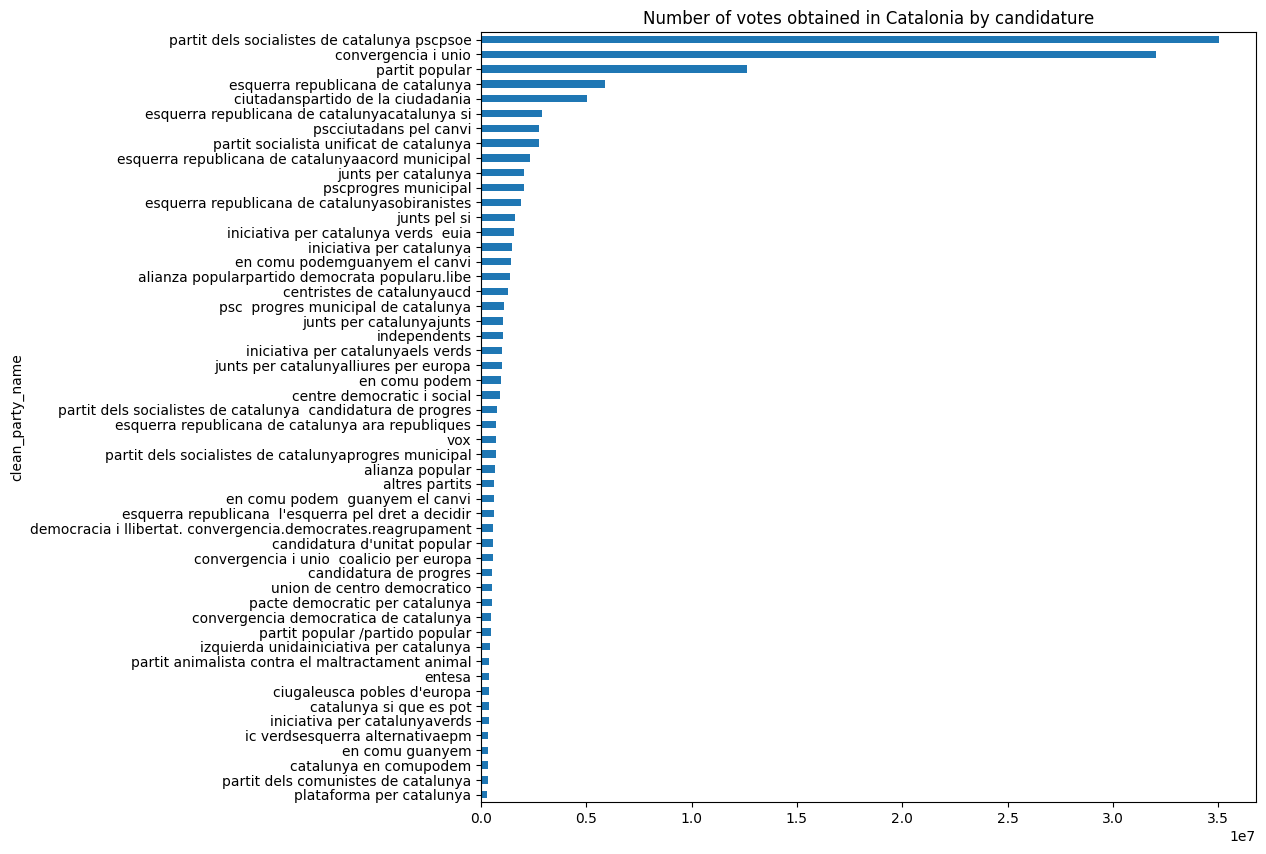

In [33]:
# plot the number of votes obtained in territory="CA" by candidature and sort them
threshold = 300000
votes_by_candidature = df[df["id_nivell_territorial"] == "CA"].groupby("clean_party_name")["vots"].sum().sort_values()
votes_by_candidature = votes_by_candidature[votes_by_candidature > threshold]
votes_by_candidature.plot(kind="barh", figsize=(10, 10), title="Number of votes obtained in Catalonia by candidature")

<Axes: >

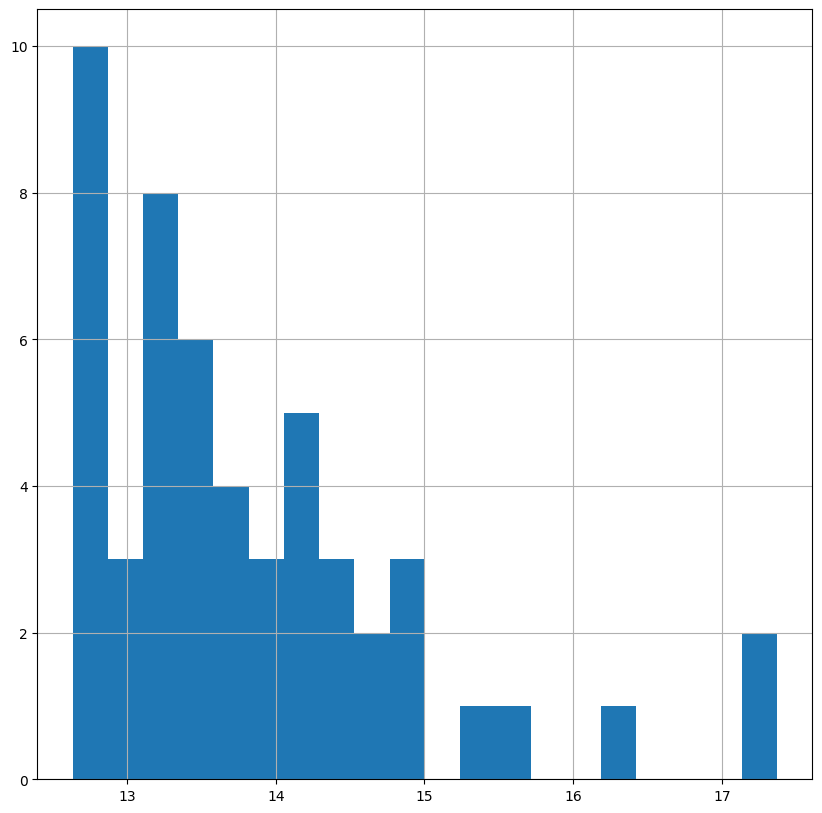

In [37]:
import numpy as np
# votes_by_candidature.hist(bins=20, figsize=(10, 10))
log_votes = np.log(votes_by_candidature)
log_votes.hist(bins=20, figsize=(10, 10))


### Plot seats by candidature

clean_party_name
a. d'independents progressistes i nacionalistes               301.000
candidatura  d'unitat  popularalternativa  municipalista      333.000
entesa                                                        370.000
candidatura d'unitat popularpoble actiu                       382.000
iniciativa per catalunyaels verds                             394.000
ic verdsesquerra alternativaepm                               397.000
iniciativa per catalunya verdseuiaentesa                      402.000
icveuiaentesa pel progres municipal                           457.000
alianza popularpartido democrata popularu.libe                481.000
ciutadanspartido de la ciudadania                             529.000
iniciativa per catalunya                                      596.000
federacio d'independents de catalunya                         783.000
partit socialista unificat de catalunya                       861.000
altres partits                                               1181.000
cen

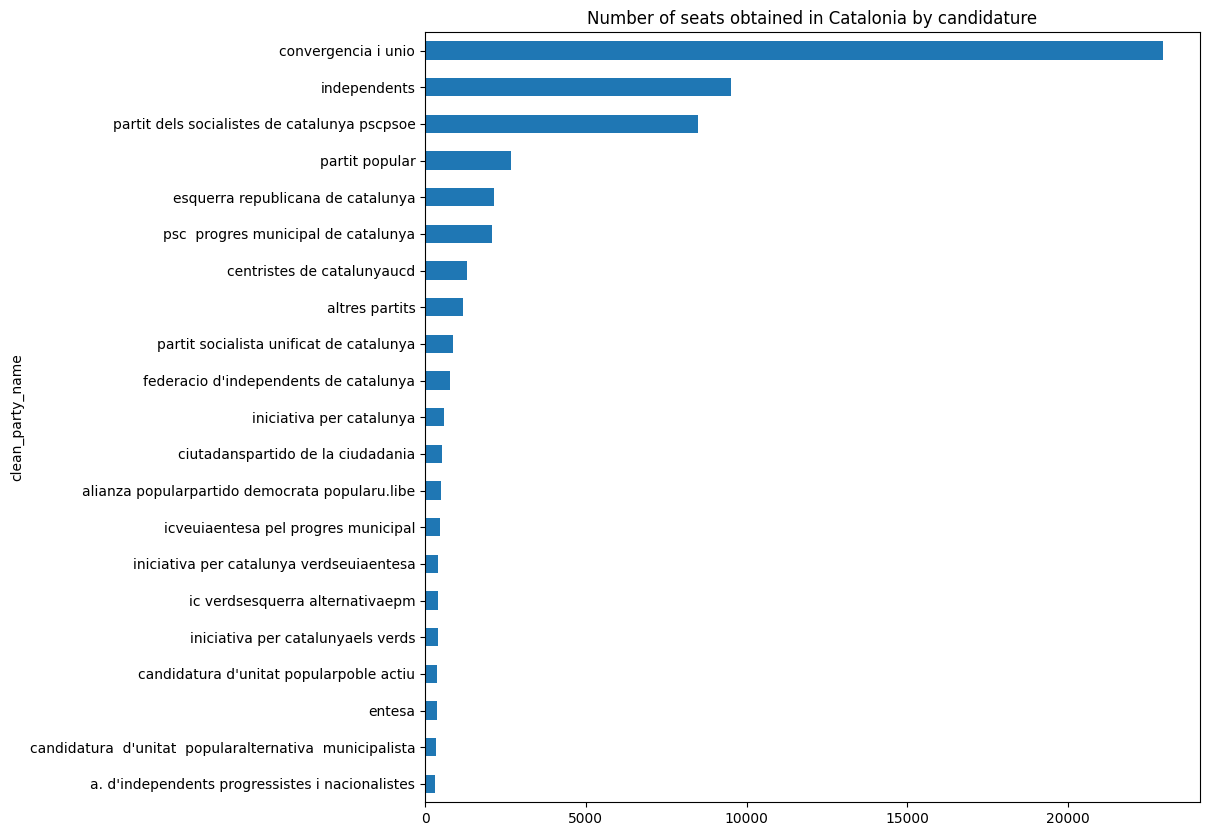

In [42]:
# plot the number of seats obtained in territory="MU" by candidature and sort them
threshold = 300
seats_by_candidature = df[df["id_nivell_territorial"] == "CA"].groupby("clean_party_name")["escons"].sum().sort_values()
seats_by_candidature = seats_by_candidature[seats_by_candidature > threshold]
seats_by_candidature.plot(kind="barh", figsize=(10, 10), title="Number of seats obtained in Catalonia by candidature")
seats_by_candidature

##

## Region statistics

### Plot number of parties by region